## **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import plot_tree
from graphviz import Digraph, nohtml

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Mahdi/anaconda3/Library/bin/Graphviz/bin/'

## **Read Data**

In [3]:
data = pd.read_csv('data/iris.csv')
data

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
data.dtypes

sepallength    float64
sepalwidth     float64
petallength    float64
petalwidth     float64
class           object
dtype: object

### *Casting object feature to category feature*

In [5]:
obj_features = data.select_dtypes('object').columns
data[obj_features] = data[obj_features].astype('category')
data.dtypes

sepallength     float64
sepalwidth      float64
petallength     float64
petalwidth      float64
class          category
dtype: object

## **Handling Missing Values**

In [6]:
data.isnull().sum()

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64

## **Look The Features**

In [7]:
data.describe(include='all')

,sepallength,sepalwidth,petallength,petalwidth,class
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Iris-setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.054000,3.758667,1.198667,NaN
std,0.828066,0.433594,1.764420,0.763161,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


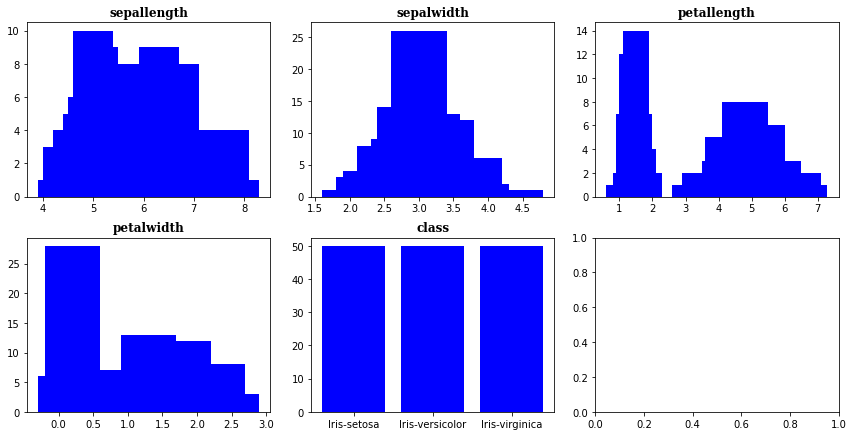

In [8]:
fig , ax = plt.subplots(2 , 3 , figsize=(12 , 6))
flat_ax = ax.flatten()
plt.tight_layout(h_pad=2, w_pad=1)
features = data.columns
for i , feature in enumerate(features):
    unq_values = data[feature].value_counts().values
    unq_index  = data[feature].value_counts().index
    flat_ax[i].bar(unq_index , unq_values , color='b')
    flat_ax[i].set_title(f'{feature}' , fontfamily='Serif',fontweight='bold')

## **Split data to Train AND Test**

In [9]:
train_set , test_set = train_test_split(data , test_size=0.2 , random_state=10)
train_set.shape ,  test_set.shape       

((120, 5), (30, 5))

## **Entropy & Gain Ratio**

In [10]:
def entropy(labels):
    p = labels.value_counts() / len(labels)
    epsilon = 0.000001
    return -sum(p * np.log2(p+epsilon))

In [11]:
entropy(train_set['class'])

1.5822505777302804

In [12]:
def gain_ratio(data , feature , target):
    e_parent = entropy(data[target])
    e_child = 0
    si = 0
    for value in data[feature].unique():
        
        if value in data[feature].value_counts().index:
            subset = data[data[feature]==value]
        else:
            subset = data[data[feature].isnull()]
            
        if len(subset) == 0:
            return 0
        
        w = len(subset) / len(data)
        e_child += w * entropy(subset[target])
        
        si += -(w * np.log2(w))
        info_gain =  e_parent - e_child
    return info_gain / si

## **Best Threshold**

In [13]:
def best_threshold(data , target):
    
    train_set = data.copy()
    kb = KBinsDiscretizer(n_bins=3 , encode='ordinal' , strategy='uniform')
    fatures_for_transform = train_set.select_dtypes('float64').columns
    train_set[fatures_for_transform] = kb.fit_transform(train_set[fatures_for_transform])

    # select discritization features
    columns = train_set.drop(target, axis=1).select_dtypes('float').columns
    best_thresh = {}

    for i , column in enumerate(columns):
    
        # Calculated Entropy of Parent
        entropy_parent = entropy(data[target])
        
        # Select Threshold
        gain_ratio_for_threshs=[]
        for thresh in np.unique(train_set[column]):
            result = np.where(train_set[column] <= thresh , 1 , 0)
        
            # Convert result and target to dataframe for Calculate Information Gain
            labels = train_set[target].values
            dataframe = pd.DataFrame(np.c_[result , labels] , columns=['feature','labels'])
            
            # Calculated Information Gain for each part
            gain_rat = gain_ratio(dataframe , 'feature' , 'labels')
            gain_ratio_for_threshs.append(gain_rat)
            
        best_thresh[column] = kb.bin_edges_[i][np.argmax(gain_ratio_for_threshs)]
    return best_thresh

In [14]:
def gain_ratio_for_numerical(data , feature , target):
    entropy_parent = entropy(data[target])
    entropy_child  = 0
    
    best_thresh = best_threshold(data , target)
    result = np.where(data[feature] <= best_thresh[feature], 1 , 0)
    labels = data[target].values
    
    dataframe = pd.DataFrame(np.c_[result , labels] , columns=['feature','labels'])
    
    gr = gain_ratio(dataframe , 'feature' , 'labels')
    return gr

In [15]:
for feature in train_set.select_dtypes('float').columns:
    
    gr = gain_ratio_for_numerical(train_set , feature , 'class')
    
    print(f'Gain Ratio for {feature} is {gr:.2f}')

Gain Ratio for sepallength is 0.26
Gain Ratio for sepalwidth is 0.26
Gain Ratio for petallength is 0.70
Gain Ratio for petalwidth is 0.73


## **Define Node**

In [16]:
class Node:
    
    def __init__(self , feature=None , label=None):
        self.feature = feature
        self.label = label
        self.children = {}
        
    def __repr__(self):
        if self.feature is not None:
            return f'DecisionNode(feature="{self.feature}", children={self.children})'
        else:
            return f'LeafNode(label="{self.label}")'

## **Define Model with PrePruning "max_depth" and "min_leaf_size" and "min_sample_split"**

In [17]:
def make_tree(data, target , depth , min_leaf_size , min_sample_split ,  count=0):
    
    # leaf node?
    if len(data[target].unique()) == 1 or len(data[target]) <= min_leaf_size or count >= depth:
        return Node(label=data[target].iloc[0])
    
    features = data.drop(target, axis=1).columns
    if len(features) == 0 or len(data) == 0:
        return Node(label=data[target].mode()[0])
    
    
    
    # calculate information gain
    gains = []
    
    for feature in features:
        if data[feature].dtype == 'float':
            gains.append(gain_ratio_for_numerical(data , feature , target))
            
        else:
            gains.append(gain_ratio(data, feature, target))
    
    # greedy search to find best feature
    max_gain_idx = np.argmax(gains)
    best_feature = features[max_gain_idx]

    
    # best threshold on numerical features
    if data[best_feature].dtype == 'float':
        best_t = best_threshold(data , target)
    
    # make a node
    if len(data[best_feature]) >= min_sample_split:
        node = Node(feature=best_feature)
    else:
        return Node(label=data[target].mode()[0])
    
    # loop over the best feature
    if data[best_feature].dtype == 'float':
        
        subset_down = data[data[best_feature] <= best_t[best_feature]].drop(best_feature, axis=1)
        subset_up   = data[data[best_feature] > best_t[best_feature]].drop(best_feature, axis=1)
        subsets = [subset_down , subset_up]
    
        node.children[f'<= {best_t[best_feature]:.2f}'] = make_tree(subset_down , target , depth , min_leaf_size , min_sample_split ,  count = count+1)
        node.children[f'> {best_t[best_feature]:.2f}'] = make_tree(subset_up , target , depth , min_leaf_size , min_sample_split , count = count+1)
        
    else:
        for value in data[best_feature].unique():
            if value in data[best_feature].value_counts().index:
                subset = data[data[best_feature] == value].drop(best_feature, axis=1)
            else:
                subset = data[data[best_feature].isnull()]
        # display(subset)
        
            node.children[value] = make_tree(subset, target , depth , min_leaf_size , min_sample_split , count = count+1)
            
    return node

In [18]:
tree = make_tree(train_set , 'class' ,  depth=10  , min_leaf_size=1 , min_sample_split=1)
tree

DecisionNode(feature="petalwidth", children={'<= 1.70': DecisionNode(feature="petallength", children={'<= 4.20': DecisionNode(feature="sepallength", children={'<= 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.57': LeafNode(label="Iris-setosa"), '> 3.57': LeafNode(label="Iris-setosa")}), '> 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.67': LeafNode(label="Iris-versicolor"), '> 3.67': LeafNode(label="Iris-setosa")})}), '> 4.20': DecisionNode(feature="sepalwidth", children={'<= 2.93': DecisionNode(feature="sepallength", children={'<= 6.03': LeafNode(label="Iris-versicolor"), '> 6.03': LeafNode(label="Iris-versicolor")}), '> 2.93': DecisionNode(feature="sepallength", children={'<= 6.60': LeafNode(label="Iris-versicolor"), '> 6.60': LeafNode(label="Iris-versicolor")})})}), '> 1.70': DecisionNode(feature="sepallength", children={'<= 7.13': DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petalle

## **Visualization**

In [19]:
def plot_tree(tree , parent=None , node_id=None):
    if node_id is None:
        node_id = '0'
        g = Digraph(node_attr={'shape': 'record' , 'height': '.1'})
        g.node(node_id , label=tree.feature , style='filled' , fillcolor='burlywood')
        
    else:
        g = parent
        g.node(node_id , label = tree.feature , style='filled' , fillcolor='#a0522d')
        
    if len(tree.children) == 0:
        g.node(node_id , label=tree.label , style='filled' , fillcolor='burlywood')
        return g
    
    for i,(value , child) in enumerate(tree.children.items()):
        child_id = f'{node_id}_{i+1}'
        plot_tree(child , g , child_id)
        g.edge(node_id , child_id , label=str(value))
        
    return g

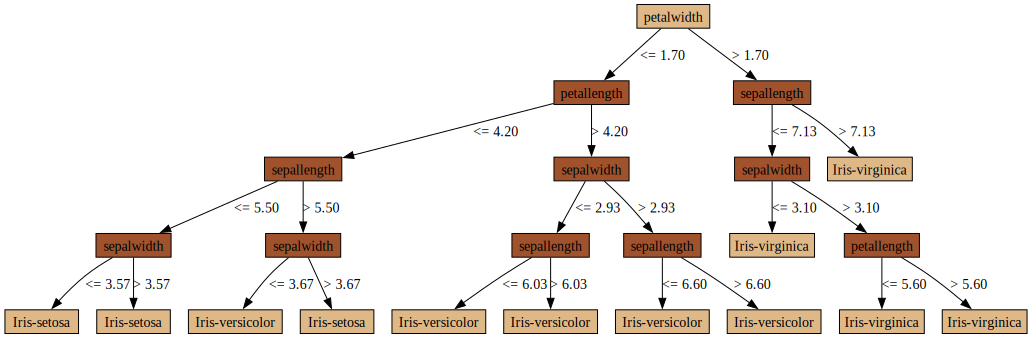

In [20]:
plot_tree(tree)

## **Prediction**

In [21]:
def pred(node , sample):
    if node.feature is None:
        return node.label
    feature_value = sample[node.feature]
    
    if feature_value in node.children:
        return pred(node.children[feature_value], sample)
    else:
        for condition in node.children:
            print(node.children)
            operator , threshold = condition.split(' ')
            threshold = float(threshold)
            
            if operator == '<=' and feature_value <= threshold:
                return pred(node.children[condition] , sample)
            
            elif operator == '>' and feature_value > threshold:
                return pred(node.children[condition] , sample)

In [22]:
prediction = [pred(tree , sample) for _, sample in test_set.iterrows()]

{'<= 1.70': DecisionNode(feature="petallength", children={'<= 4.20': DecisionNode(feature="sepallength", children={'<= 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.57': LeafNode(label="Iris-setosa"), '> 3.57': LeafNode(label="Iris-setosa")}), '> 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.67': LeafNode(label="Iris-versicolor"), '> 3.67': LeafNode(label="Iris-setosa")})}), '> 4.20': DecisionNode(feature="sepalwidth", children={'<= 2.93': DecisionNode(feature="sepallength", children={'<= 6.03': LeafNode(label="Iris-versicolor"), '> 6.03': LeafNode(label="Iris-versicolor")}), '> 2.93': DecisionNode(feature="sepallength", children={'<= 6.60': LeafNode(label="Iris-versicolor"), '> 6.60': LeafNode(label="Iris-versicolor")})})}), '> 1.70': DecisionNode(feature="sepallength", children={'<= 7.13': DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="

In [23]:
print(f'acuuracy of tree is {accuracy_score(prediction , test_set.iloc[: , -1]):.2f}')

acuuracy of tree is 0.93


In [24]:
def find_decision_features(node , decision_features = []):
    
    for key , value in node.children.items():
        if value.feature != None:
            
            decision_features.append(value.feature)
            find_decision_features(value)   
            
    return decision_features

In [25]:
find_decision_features(tree)

['petallength',
 'sepallength',
 'sepalwidth',
 'sepalwidth',
 'sepalwidth',
 'sepallength',
 'sepallength',
 'sepallength',
 'sepalwidth',
 'petallength']

In [26]:
tree

DecisionNode(feature="petalwidth", children={'<= 1.70': DecisionNode(feature="petallength", children={'<= 4.20': DecisionNode(feature="sepallength", children={'<= 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.57': LeafNode(label="Iris-setosa"), '> 3.57': LeafNode(label="Iris-setosa")}), '> 5.50': DecisionNode(feature="sepalwidth", children={'<= 3.67': LeafNode(label="Iris-versicolor"), '> 3.67': LeafNode(label="Iris-setosa")})}), '> 4.20': DecisionNode(feature="sepalwidth", children={'<= 2.93': DecisionNode(feature="sepallength", children={'<= 6.03': LeafNode(label="Iris-versicolor"), '> 6.03': LeafNode(label="Iris-versicolor")}), '> 2.93': DecisionNode(feature="sepallength", children={'<= 6.60': LeafNode(label="Iris-versicolor"), '> 6.60': LeafNode(label="Iris-versicolor")})})}), '> 1.70': DecisionNode(feature="sepallength", children={'<= 7.13': DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petalle

In [85]:
def find_decision_features(node , decision_nodes = []):
    
    for key , value in node.children.items():
        if value.feature != None:
            
            decision_nodes.append(node.children[key])
            
            find_decision_features(value)
            
    return decision_nodes

In [86]:
decision_features = find_decision_features(tree)
len(decision_features)

10

In [92]:
decision_features.reverse()

In [101]:
decision_features[1]

DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})})

In [100]:
decision_features[0]

DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})

In [105]:
for i , des_feature in enumerate(decision_features):
    keys = des_feature.children.keys()
    for key in keys:
        if des_feature.children[key].feature == None:
            print(des_feature)
    

DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})
DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})
DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})})
DecisionNode(feature="sepallength", children={'<= 7.13': DecisionNode(feature="sepalwidth", children={'<= 3.10': LeafNode(label="Iris-virginica"), '> 3.10': DecisionNode(feature="petallength", children={'<= 5.60': LeafNode(label="Iris-virginica"), '> 5.60': LeafNode(label="Iris-virginica")})}), '> 7.13': LeafNode(label="Iris-virginica")})
DecisionNode(feature="sepallength", children={'<= 6.60': LeafNode(label="Iris-versicolor"), '> 6.60': LeafNode(label="Iris-versicolor")})
DecisionNod